In [102]:
#  Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [104]:
# Load the dataset
df = pd.read_csv(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\CyberSecurity\datasets\HITECH_Cleaned.csv")
# Ensure breach_submission_date is datetime
df["breach_submission_date"] = pd.to_datetime(df["breach_submission_date"])

# Count monthly breaches
monthly_df = df.groupby(pd.Grouper(key="breach_submission_date", freq="ME")).size().reset_index(name="breach_count")
monthly_df.set_index("breach_submission_date", inplace=True)

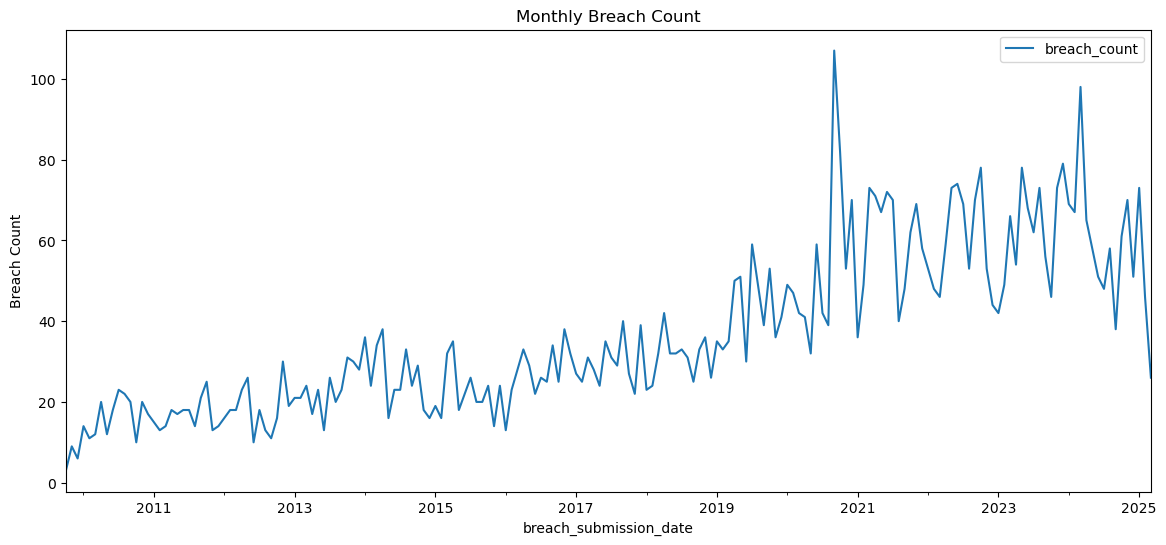

In [105]:
# Plot the monthly breach count
monthly_df.plot(figsize=(14,6), title="Monthly Breach Count")
plt.ylabel("Breach Count")
plt.show()


In [108]:
#  Normalize time series for LSTM inputscaler = MinMaxScaler()
data_scaled = scaler.fit_transform(monthly_df)

# Save unscaled for later use
original_data = monthly_df.values


In [110]:
#  Function to create sequences of time steps
def create_sequences(data, time_steps=6):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
    return np.array(X)

TIME_STEPS = 6
X_train = create_sequences(data_scaled, TIME_STEPS)


In [112]:
# Build LSTM Autoencoder
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 6, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 6, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 6, 1)                │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.0779 - val_loss: 0.0893
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0270 - val_loss: 0.0762
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0216 - val_loss: 0.0494
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0167 - val_loss: 0.0372
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0148 - val_loss: 0.0215
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - val_loss: 0.0198
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0091 - val_loss: 0.0178
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - val_loss: 0.0164
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065 - val_loss: 0.0159
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0081 - val_loss: 0.0150
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0142
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/ste

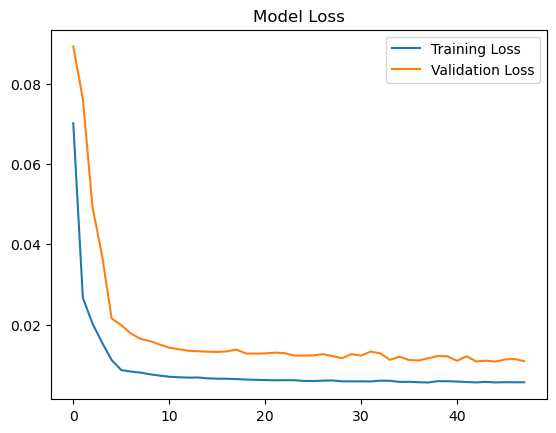

In [115]:
# Visualize loss curve
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


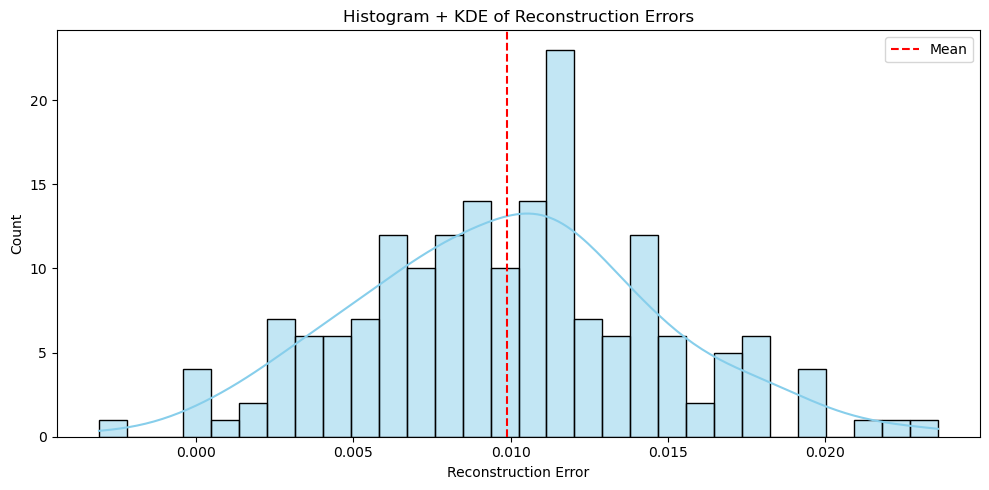

0.9153901190530853

In [118]:
import seaborn as sns
from scipy.stats import shapiro

# Plot histogram and KDE of reconstruction errors to inspect distribution visually
plt.figure(figsize=(10, 5))
sns.histplot(mse, kde=True, bins=30, color='skyblue')
plt.axvline(np.mean(mse), color='red', linestyle='--', label='Mean')
plt.title("Histogram + KDE of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test to check if errors follow a Gaussian distribution
stat, p_value = shapiro(mse)
p_value  # If p < 0.05, data is NOT normally distributed (reject H0)


In [136]:
# Predict reconstructed sequences and calculate reconstruction error
X_pred = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - X_pred, 2), axis=(1, 2))

# Set anomaly threshold as mean + 3×standard deviation
threshold = np.mean(mse) + 3 * np.std(mse)
print("Anomaly Threshold (mean + 3*std):", threshold)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Anomaly Threshold (mean + 3*std): 0.03170818177821728


In [138]:
# Identify anomalies using threshold
anomalies = mse > threshold
print(f"Total Anomalies Detected: {np.sum(anomalies)}")

# Create a timestamp-aligned series of anomaly flags
anomaly_timestamps = monthly_df.index[TIME_STEPS:]
anomaly_series = pd.Series(anomalies, index=anomaly_timestamps)


Total Anomalies Detected: 5


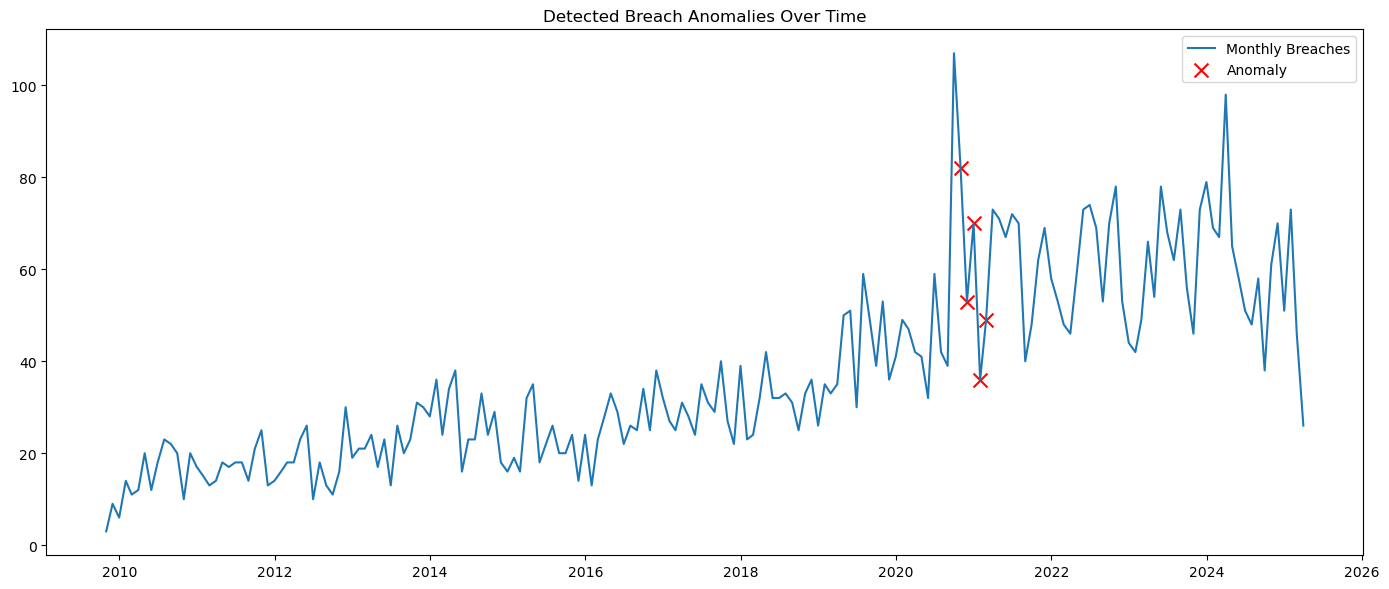

In [140]:
# Plot monthly breach count and highlight anomalies in red
plt.figure(figsize=(14,6))
plt.plot(monthly_df.index, monthly_df["breach_count"], label="Monthly Breaches")
plt.scatter(anomaly_series[anomaly_series].index,
            monthly_df.loc[anomaly_series[anomaly_series].index, "breach_count"],
            color="red", label="Anomaly", marker="x", s=100)
plt.title("Detected Breach Anomalies Over Time")
plt.legend()
plt.tight_layout()
plt.show()


In [142]:
# Compute anomaly threshold using 95th percentile (non-Gaussian safe)
threshold_95 = np.percentile(mse, 95)
print("95th Percentile Threshold:", threshold_95)

# Generate new anomaly flags
anomalies_95 = mse > threshold_95
anomaly_series_95 = pd.Series(anomalies_95, index=anomaly_timestamps)


95th Percentile Threshold: 0.016817420753243557


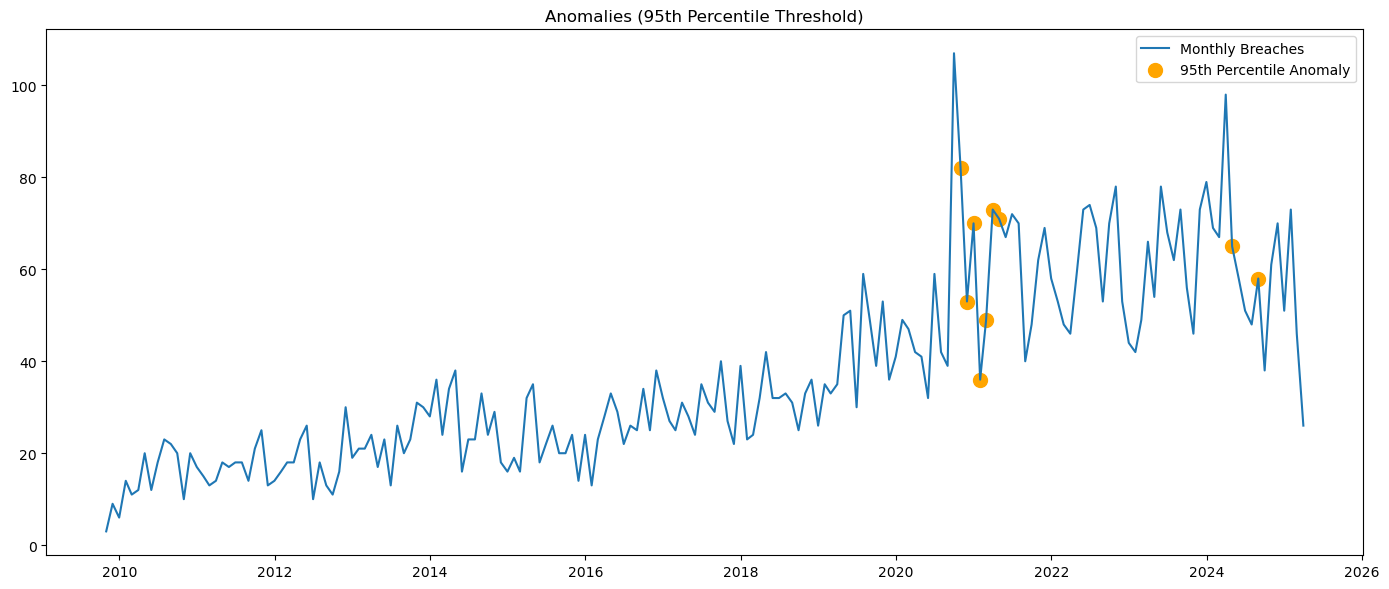

In [146]:
# Visualize anomalies flagged using percentile-based threshold
plt.figure(figsize=(14,6))
plt.plot(monthly_df.index, monthly_df["breach_count"], label="Monthly Breaches")
plt.scatter(anomaly_series_95[anomaly_series_95].index,
            monthly_df.loc[anomaly_series_95[anomaly_series_95].index, "breach_count"],
            color="orange", label="95th Percentile Anomaly", marker="o", s=100)
plt.title("Anomalies (95th Percentile Threshold)")
plt.legend()
plt.tight_layout()
plt.show()


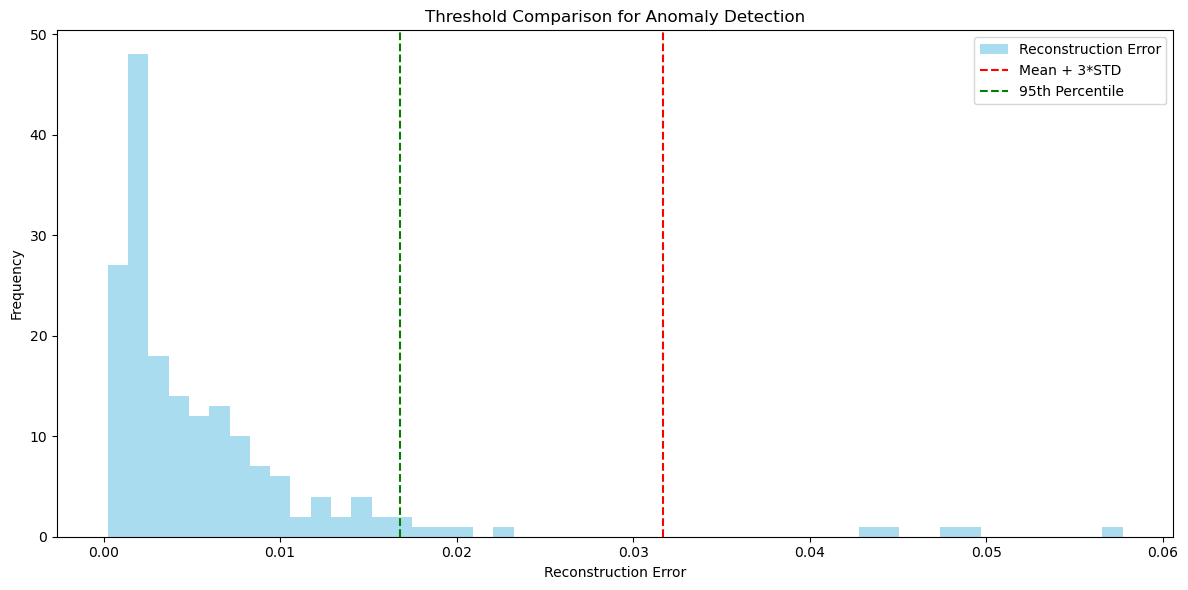

In [148]:
# Compare mean+3std and 95th percentile thresholds visually
plt.figure(figsize=(12, 6))
plt.hist(mse, bins=50, alpha=0.7, color='skyblue', label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Mean + 3*STD')
plt.axvline(threshold_95, color='green', linestyle='--', label='95th Percentile')
plt.title("Threshold Comparison for Anomaly Detection")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


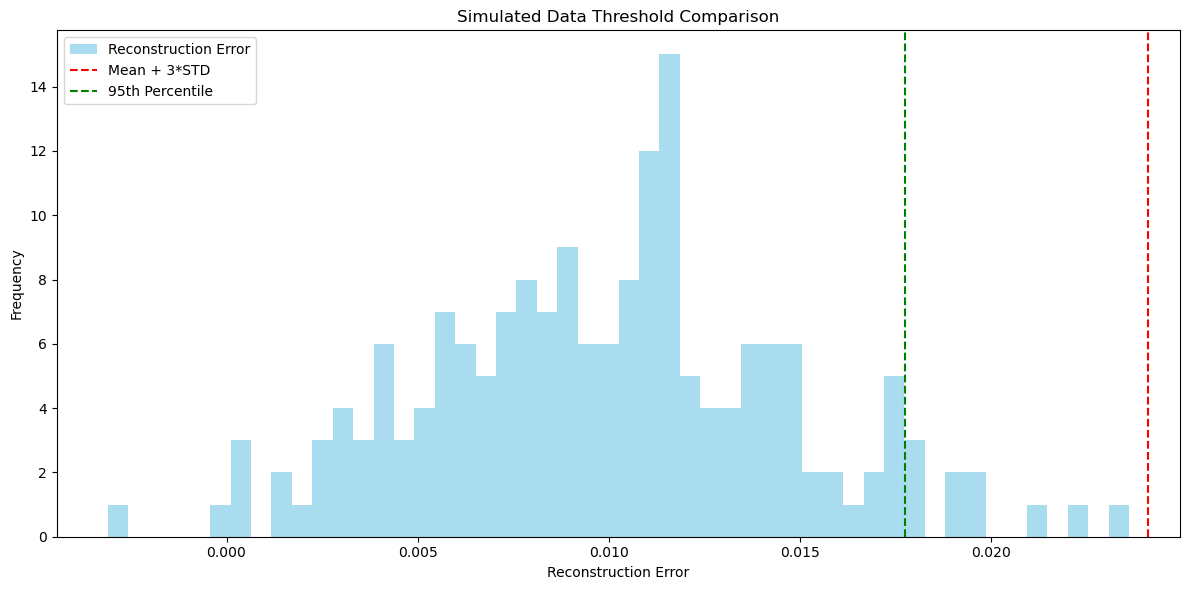

In [152]:
# Simulate MSE errors if not available
np.random.seed(42)
mse = np.random.normal(loc=0.01, scale=0.005, size=180)

# Recalculate both thresholds on simulated data
threshold = np.mean(mse) + 3 * np.std(mse)
threshold_95 = np.percentile(mse, 95)

# Visualize again for simulated data
plt.figure(figsize=(12, 6))
plt.hist(mse, bins=50, alpha=0.7, color='skyblue', label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Mean + 3*STD')
plt.axvline(threshold_95, color='green', linestyle='--', label='95th Percentile')
plt.title("Simulated Data Threshold Comparison")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
